In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('Pakistan Largest Ecommerce Dataset.csv', parse_dates=['created_at'], index_col='created_at')


In [14]:
monthly_sales = df['grand_total'].resample('M').sum()


In [15]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("The series is not stationary")
    else:
        print("The series is stationary")

check_stationarity(monthly_sales)

ADF Statistic: -5.075082667902772
p-value: 1.572980041392922e-05
The series is stationary


In [16]:
monthly_sales_diff = monthly_sales.diff().dropna()
check_stationarity(monthly_sales_diff)


ADF Statistic: -4.710942972240953
p-value: 8.025848842528474e-05
The series is stationary


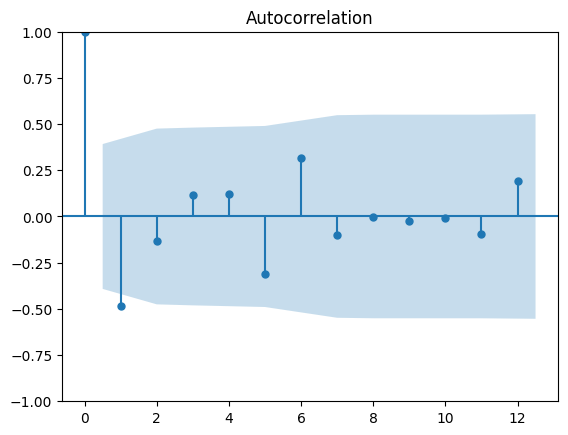

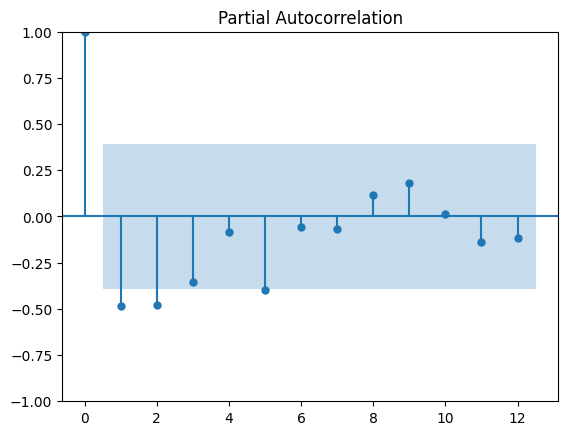

In [17]:
plot_acf(monthly_sales_diff)
plot_pacf(monthly_sales_diff)
plt.show()

In [18]:
auto_model = auto_arima(monthly_sales, seasonal=False, stepwise=True, trace=True, 
                        error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1039.064, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1034.297, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1027.934, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1037.093, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1028.013, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1032.759, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1023.142, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1024.463, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1024.612, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1032.351, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1026.582, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.605 seconds
                               S

In [19]:
model = ARIMA(monthly_sales, order=auto_model.order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            grand_total   No. Observations:                   26
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -509.571
Date:                Mon, 07 Oct 2024   AIC                           1023.142
Time:                        11:37:59   BIC                           1025.580
Sample:                    07-31-2016   HQIC                          1023.818
                         - 08-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8398      0.188     -4.477      0.000      -1.207      -0.472
sigma2       3.18e+16   5.52e-19   5.76e+34      0.000    3.18e+16    3.18e+16
Ljung-Box (L1) (Q):                   1.97   Jarque-

In [20]:
forecast_periods = 2
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_ci = forecast.conf_int()

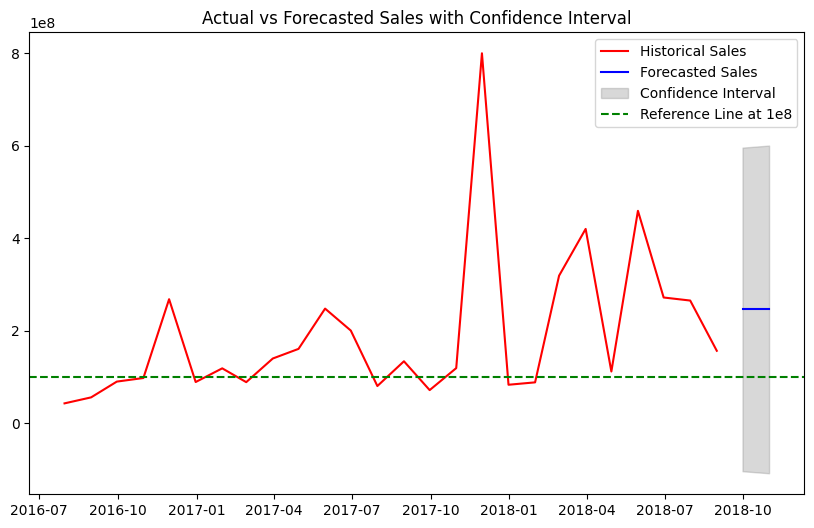

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales, label='Historical Sales', color='red')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='blue', label='Forecasted Sales')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
plt.axhline(y=1e8, color='green', linestyle='--', label='Reference Line at 1e8')
plt.title('Actual vs Forecasted Sales with Confidence Interval')
plt.legend()
plt.show()